# Object Detection notebook
## CS152 October 2, 2018  Neil Rhodes

We look at Object Detection

Code based on [fastai style transfer notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/style-transfer.ipynb).

In [305]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We are interested in finding objects and their bounding boxes within images.


In [306]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *

from fastai.sgdr import *
from fastai.plots import *

import collections
import json
from matplotlib import patheffects, patches
import pandas as pd
from pathlib import Path

## Utility Functions

In [307]:
def denorm(tensor, denormalizer):
    """Does the opposite of the transformation from tfms_from_model"""
    
    # Even though the transformer returned from tfms_from_model moves the channels
    # (from width, height, depth) to (1, channels, width, height), the denormalizer
    # returned from tfms_from_model doesn't convert back
    wid_height_depth = np.moveaxis(to_np(tensor),1,-1)[0]
    return denormalizer(wid_height_depth)

In [308]:
def draw_with_size(image, size_in_inches):
    plt.figure(figsize=(size_in_inches, size_in_inches))
    plt.imshow(image);

# Getting the data

We'll be using the Pascal dataset, downloaded from XXX

In [309]:
PATH = Path('../../data/pascal')
TRAIN_JSON = 'pascal_train2007.json'
VAL_JSON = 'pascal_val2007.json'

In [310]:
with (PATH/TRAIN_JSON).open() as f:
    dict_train = json.load(f)
dict_train.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [311]:
IMAGES, _, ANNOTATIONS, CATEGORIES  = dict_train.keys()

In [312]:
id_to_image_info = {
    f['id']: {
        'file': f['file_name'], 
        'height': f['height'],
        'width': f['width'] 
    } for f in dict_train[IMAGES]}

We'll use (left, top, right, bottom) for our bounding box coordinates.  VOC uses (top, left, height, width). These are conversions

In [313]:
def voc_to_bb(bb):
    top, left, height, width = bb
    return (left, top, left + width, top + height)

def bb_to_voc(voc):
    left, top, right, bottom = voc
    return (top, left, bottom - top, right - left)

In [314]:
images = collections.defaultdict(list)
for annotation in dict_train[ANNOTATIONS]:
    bbox = annotation['bbox']
    image_info = id_to_image_info[annotation['image_id']]
    images[image_info['file']].append(
        {
            'bb': voc_to_bb(bbox),
            'category': annotation['category_id']
        })
images = dict(images) # Once we've created it, we don't want defaultdict behavior

In [315]:
categories = {cat['id']: cat['name'] for cat in dict_train[CATEGORIES]}
categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [316]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
(PATH / JPEGS / '000012.jpg').open()

<_io.TextIOWrapper name='../../data/pascal/VOCdevkit/VOC2007/JPEGImages/000012.jpg' mode='r' encoding='UTF-8'>

In [317]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [318]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [319]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [320]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

Draw one of our bounding boxes:

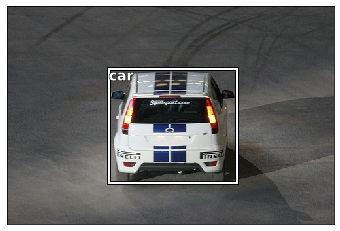

In [321]:
SAMPLE_FILE = '000012.jpg'
im = open_image(PATH / JPEGS / SAMPLE_FILE)
ax = show_img(im)
b = bb_to_voc(images[SAMPLE_FILE][0]['bb'])
draw_rect(ax, b)
draw_text(ax, b[:2], categories[images[SAMPLE_FILE][0]['category']])

Apply the model transformation to the random image, and then create a PyTorch Variable from it, requesting gradients for the image.

In [322]:
def draw_image(image, annotations):
    ax = show_img(image)
    for annotation in annotations:
        b = bb_to_voc(annotation['bb'])
        draw_rect(ax, b)
        draw_text(ax, b[:2], categories[annotation['category']])

Let's look at the model.

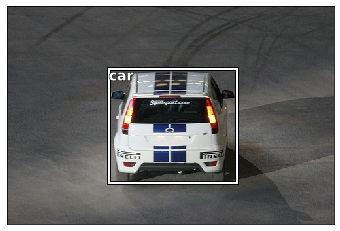

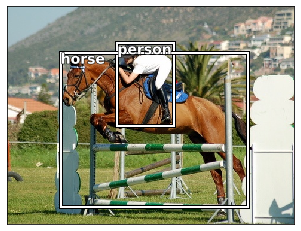

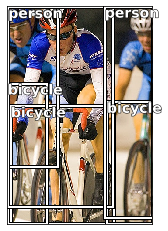

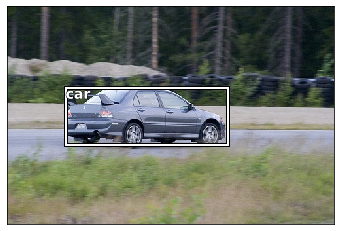

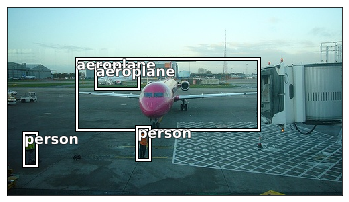

In [323]:
i = 0
for name, annotations in images.items():
    if i == 5:
        break
    i += 1
    draw_image(open_image(PATH/JPEGS/name), annotations)

## Classifier for largest object in image

First, let's set up the data correctly.

In [324]:
def largest_annotation(annotations):
    def area(a):
        bbox = a['bb']
        # Multiply width * height
        return np.prod(np.array(bbox[2:]) - np.array(bbox[:2]))
    return sorted(annotations, key=area)[-1]
largest_annotation(images['000012.jpg'])

{'bb': (96, 155, 270, 351), 'category': 7}

Our x is the image name. y is the desired category

In [325]:
file_and_cat = {'file': [], 'category': []}
for file, annotations in images.items():
    file_and_cat['file'].append(file)
    file_and_cat['category'].append(
        categories[largest_annotation(annotations)['category']])
df = pd.DataFrame(file_and_cat, columns=['file', 'category'])
df.to_csv('file_and_cat.csv', index=False)

Now, we can create a learner. 

In [326]:
arch=resnet34
sz=228
tfms = tfms_from_model(
    resnet34, sz, 
    aug_tfms=transforms_side_on, crop_type=CropType.NO, max_zoom=1.1
)
data = ImageClassifierData.from_csv(PATH, JPEGS, 'file_and_cat.csv', tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.opt_fn = optim.Adam

In [327]:
lrf=learn.lr_find(1e-5,100)

 28%|██▊       | 9/32 [00:00<00:01, 22.32it/s, loss=3.64]


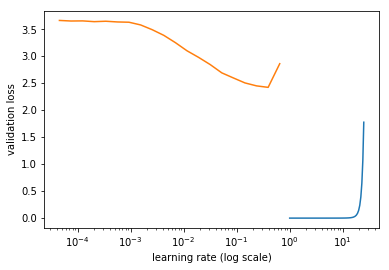

In [328]:
learn.sched.plot_lr()
learn.sched.plot(n_skip=3, n_skip_end=1)

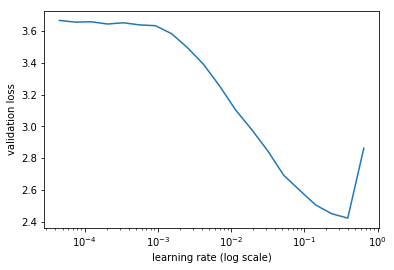

In [329]:
learn.sched.plot(n_skip=3, n_skip_end=1)

In [330]:
lr=0.1
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      2.919414   1.659121   0.742     



[array([1.65912]), 0.7419999985694885]

In [331]:
lrs = np.array([lr * 10e-2, lr * 10e-1, lr])
learn.freeze_to(-2)

We run the optimizer step function 1000 times. The parameter we pass in is a closure that does one step.
The call to ```partial``` does a partial evaluation of the ```step``` function; that is, it creates a new function which
is equivalent to calling ```step(content_loss)```.

In [332]:
learn.fit(lr/10, 3, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      1.551472   1.183016   0.804     
    1      1.307247   1.134047   0.788     
    2      1.123442   1.031345   0.788     
    3      0.965917   0.948092   0.8       
    4      0.796744   0.911194   0.802     
    5      0.68894    0.900355   0.798     
    6      0.654612   0.863448   0.802     
    7      0.562505   0.900103   0.8       
    8      0.512428   0.868267   0.79      
    9      0.433509   0.85642    0.798     
    10     0.385699   0.804982   0.798     
    11     0.340429   0.840467   0.806     
    12     0.307082   0.834797   0.802     
    13     0.291774   0.819799   0.802     



[array([0.8198]), 0.8020000009536743]

In [343]:
x,y = next(iter(data.val_dl))
probs = F.softmax(predict_batch(learn.models.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


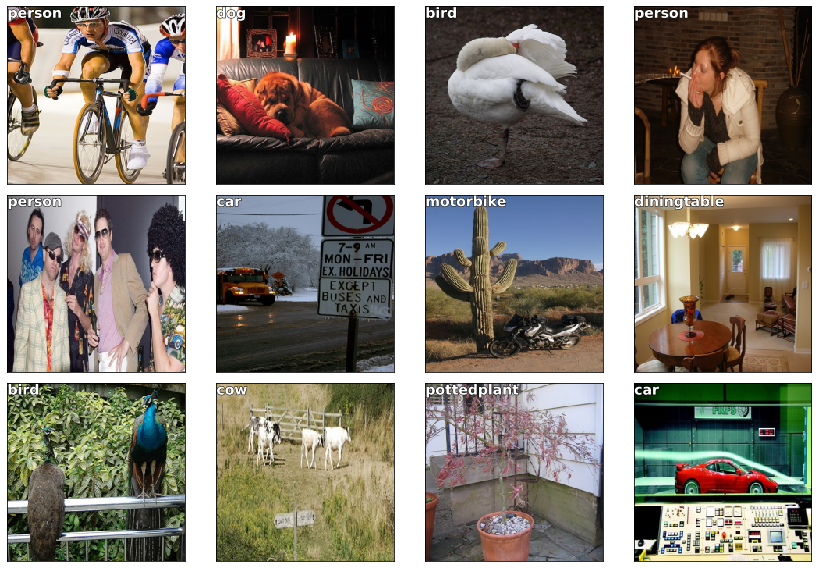

In [345]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=data.val_ds.denorm(x)[i]
    b = data.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

## Predicting bounding box of largest object 

In [493]:
FILES_AND_BB_CSV = PATH/'tmp'/'files_and_bb.csv'

file_and_bb = {'fname': [], 'bb': []}
count = 0
for file, annotations in images.items():
    file_and_bb['fname'].append(file)
    file_and_bb['bb'].append(
        " ".join(map(str, largest_annotation(annotations)['bb'])))
    count = count + 1
    #if count > 9:
        #break # temporary; suport just one picture
df = pd.DataFrame(file_and_bb, columns=['fname', 'bb'])
#print(df.head())
df.to_csv(FILES_AND_BB_CSV, index=False)
FILES_AND_BB_CSV.open().readlines()[:4]

['fname,bb\n',
 '000012.jpg,96 155 270 351\n',
 '000017.jpg,77 89 336 403\n',
 '000023.jpg,1 2 462 243\n']

In [436]:
images['000012.jpg']

[{'bb': (96, 155, 270, 351), 'category': 7}]

Create a learner

In [496]:
arch=resnet34
sz=228
aug_tfms = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]
tfms = tfms_from_model(
    resnet34, sz, 
    aug_tfms=aug_tfms,
    max_zoom=1.1,
    crop_type=CropType.NO, 
    tfm_y=TfmType.COORD
)
data = ImageClassifierData.from_csv(PATH, JPEGS, FILES_AND_BB_CSV,
                                    tfms=tfms,
                                    continuous=True)
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(arch, data,
                               #custom_head=head_reg4
                              )
learn.opt_fn = optim.Adam
#learn.crit = nn.L1Loss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


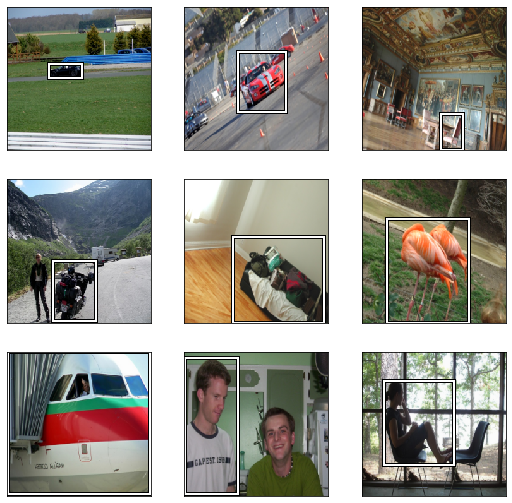

In [497]:
fig,axes = plt.subplots(3,3, figsize=(9,9))
#x,y=next(iter(data.trn_dl)) # assumes batch size is larger than axes
for i,ax in enumerate(axes.flat):
    x,y=next(iter(data.trn_dl)) # assumes batch size is larger than axes
    ima=data.val_ds.denorm(to_np(x))[i]
    b = bb_to_voc(to_np(y[i]))
    #print(y[i], b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [378]:
lrf=learn.lr_find(1e-5,100)

 91%|█████████ | 29/32 [00:00<00:00, 15.15it/s, loss=151]


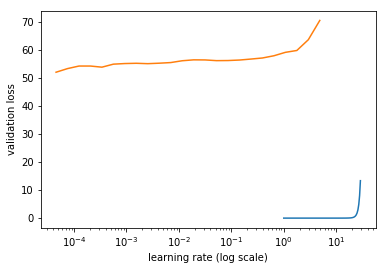

In [379]:
learn.sched.plot_lr()
learn.sched.plot(n_skip=3, n_skip_end=1)

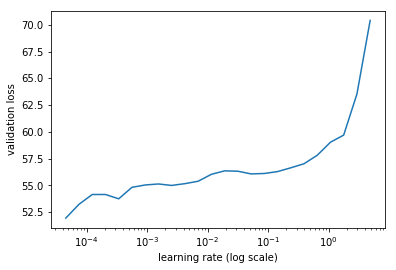

In [380]:
learn.sched.plot(n_skip=3, n_skip_end=1)

In [ ]:
lr=0.1
learn.fit(lr, 1, cycle_len=1)

In [485]:
lrs = np.array([lr * 10e-2, lr * 10e-1, lr])
learn.freeze_to(-2)

In [486]:
learn.fit(lr/10, 3, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      224.253357 208.747192
    1      224.23759  208.793274
    2      224.289884 208.615387
    3      224.208252 208.248474
    4      224.221221 208.103821
    5      224.12613  208.077866
    6      224.117804 207.829086
    7      224.041477 207.619049
    8      223.993387 207.417648
    9      223.912557 207.280762
    10     223.844357 207.197693
    11     223.762076 207.196564
    12     223.705387 207.230408
    13     223.651546 207.2612  



[array([207.2612])]

In [488]:
x,y = next(iter(data.val_dl))
x,preds = to_np(x),to_np(predict_batch(learn.models.model, x))
print(y[:5], preds[:5])


  49   43  209  190
  36   18  156  218
[torch.cuda.FloatTensor of size 2x4 (GPU 0)]
 [[1.28786 2.31926 2.8707  2.28256]
 [1.46685 0.80007 1.52434 1.35874]]


(2.319264, 1.2878646, -0.036700487, 1.5828348)
(0.8000687, 1.4668477, 0.5586671, 0.057487488)


IndexError: index 2 is out of bounds for axis 0 with size 2

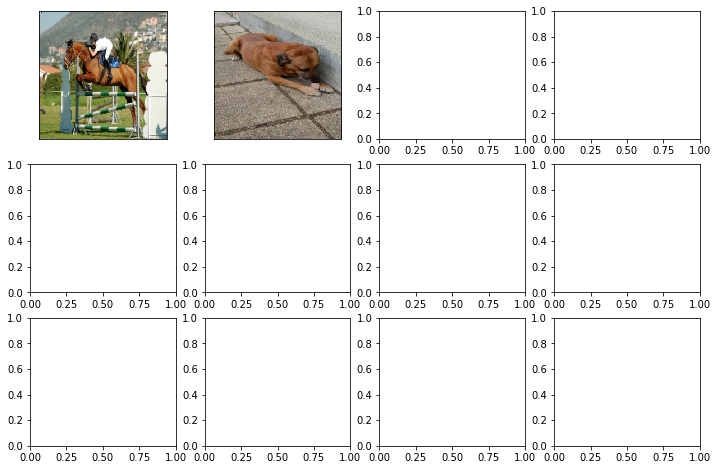

In [489]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=data.val_ds.denorm(x)[i]
    bb = preds[i]
    ax = show_img(ima, ax=ax)
    b = bb_to_voc(preds[i])
    print(b)
    draw_rect(ax, b)

plt.tight_layout()